## 1 分析背景和目的
### 1.1 背景
数据是选取的美国网上唱片公司CDNow中1997年1月到1998年6月的用户消费数据来分析消费行为。
### 1.2 目的
对数据分析，得出用户全体消费行为特征，建立RFM模型，分析消费趋势、复购率、回购率
### 1.3 模块导入和数据导入

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
# 源数据没有列名，names指定列名，sep通过任意空格分割
df = pd.read_table('./CDNOW_master.txt',names = ['user_id', 'order_dt', 'order_products', 'order_amount'], sep = '\s+')
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


数据说明  
user_id：用户ID  
order_dt：下单时间  
order_products:购买产品数  
order_amount:订单金额  

In [4]:
print(df.info())
print('===============分割线================')
print(df.describe())
print('===============分割线================')
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB
None
===============分割线================
            user_id      order_dt  order_products  order_amount
count  69659.000000  6.965900e+04    69659.000000  69659.000000
mean   11470.854592  1.997228e+07        2.410040     35.893648
std     6819.904848  3.837735e+03        2.333924     36.281942
min        1.000000  1.997010e+07        1.000000      0.000000
25%     5506.000000  1.997022e+07        1.000000     14.490000
50%    11410.000000  1.997042e+07        2.000000     25.980000
75%    17273.000000  1.997111e+07        3.000000     43.700000
max    23570.000000 

(69659, 4)

## 2 数据处理
#### 2.1 重复值处理

In [5]:
print('重复值:',df.duplicated().sum())
# 删除重复值
df.drop_duplicates()

重复值: 255


,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76
...,...,...,...,...
69654,23568,19970405,4,83.74
69655,23568,19970422,1,14.99
69656,23569,19970325,2,25.74
69657,23570,19970325,3,51.12


In [6]:
df.isnull().sum()

user_id           0
order_dt          0
order_products    0
order_amount      0
dtype: int64

数据无缺失值

#### 2.2 一致化处理
将order_dt的类型转换为datetime

In [7]:
df['order_dt'] = pd.to_datetime(df['order_dt'], format='%Y%m%d')
# 给数据集增加 年 月 日 季度  四个字段 下面的方式添加的类型是int
""" df['year'] = df['order_dt'].dt.year
df['month'] = df['order_dt'].dt.month
df['day'] = df['order_dt'].dt.day
df['quarter'] = df['order_dt'].dt.quarter
"""
# 使用下面的方式来添加 年 月 日 等信息，下面的方式添加的会是datetime类型
df['year'] = df.order_dt.values.astype('datetime64[Y]')
df['month'] = df.order_dt.values.astype('datetime64[M]')
df['quarter'] = df['order_dt'].dt.quarter
df

,user_id,order_dt,order_products,order_amount,year,month,quarter
0,1,1997-01-01,1,11.77,1997-01-01,1997-01-01,1
1,2,1997-01-12,1,12.00,1997-01-01,1997-01-01,1
2,2,1997-01-12,5,77.00,1997-01-01,1997-01-01,1
3,3,1997-01-02,2,20.76,1997-01-01,1997-01-01,1
4,3,1997-03-30,2,20.76,1997-01-01,1997-03-01,1
...,...,...,...,...,...,...,...
69654,23568,1997-04-05,4,83.74,1997-01-01,1997-04-01,2
69655,23568,1997-04-22,1,14.99,1997-01-01,1997-04-01,2
69656,23569,1997-03-25,2,25.74,1997-01-01,1997-03-01,1
69657,23570,1997-03-25,3,51.12,1997-01-01,1997-03-01,1


## 3 分析相关指标

In [8]:
# 订单层面的统计
df[['order_products', 'order_amount']].describe()

,order_products,order_amount
count,69659.000000,69659.000000
mean,2.410040,35.893648
std,2.333924,36.281942
min,1.000000,0.000000
25%,1.000000,14.490000
50%,2.000000,25.980000
75%,3.000000,43.700000
max,99.000000,1286.010000


订单的层面上进行统计  
单个订单商品数量的四分之三分位是3，说明绝大部分订单的购买量都比较低。  

In [9]:
# 用户层面统计分析
# 分组后求和
df.groupby('user_id')['order_products', 'order_amount'].sum().describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


用户层面统计分析  
结合在订单层面上的统计来看，有一部分大客户拉高了平均值。
### 3.1 消费趋势分析

#### 整体的消费趋势分析

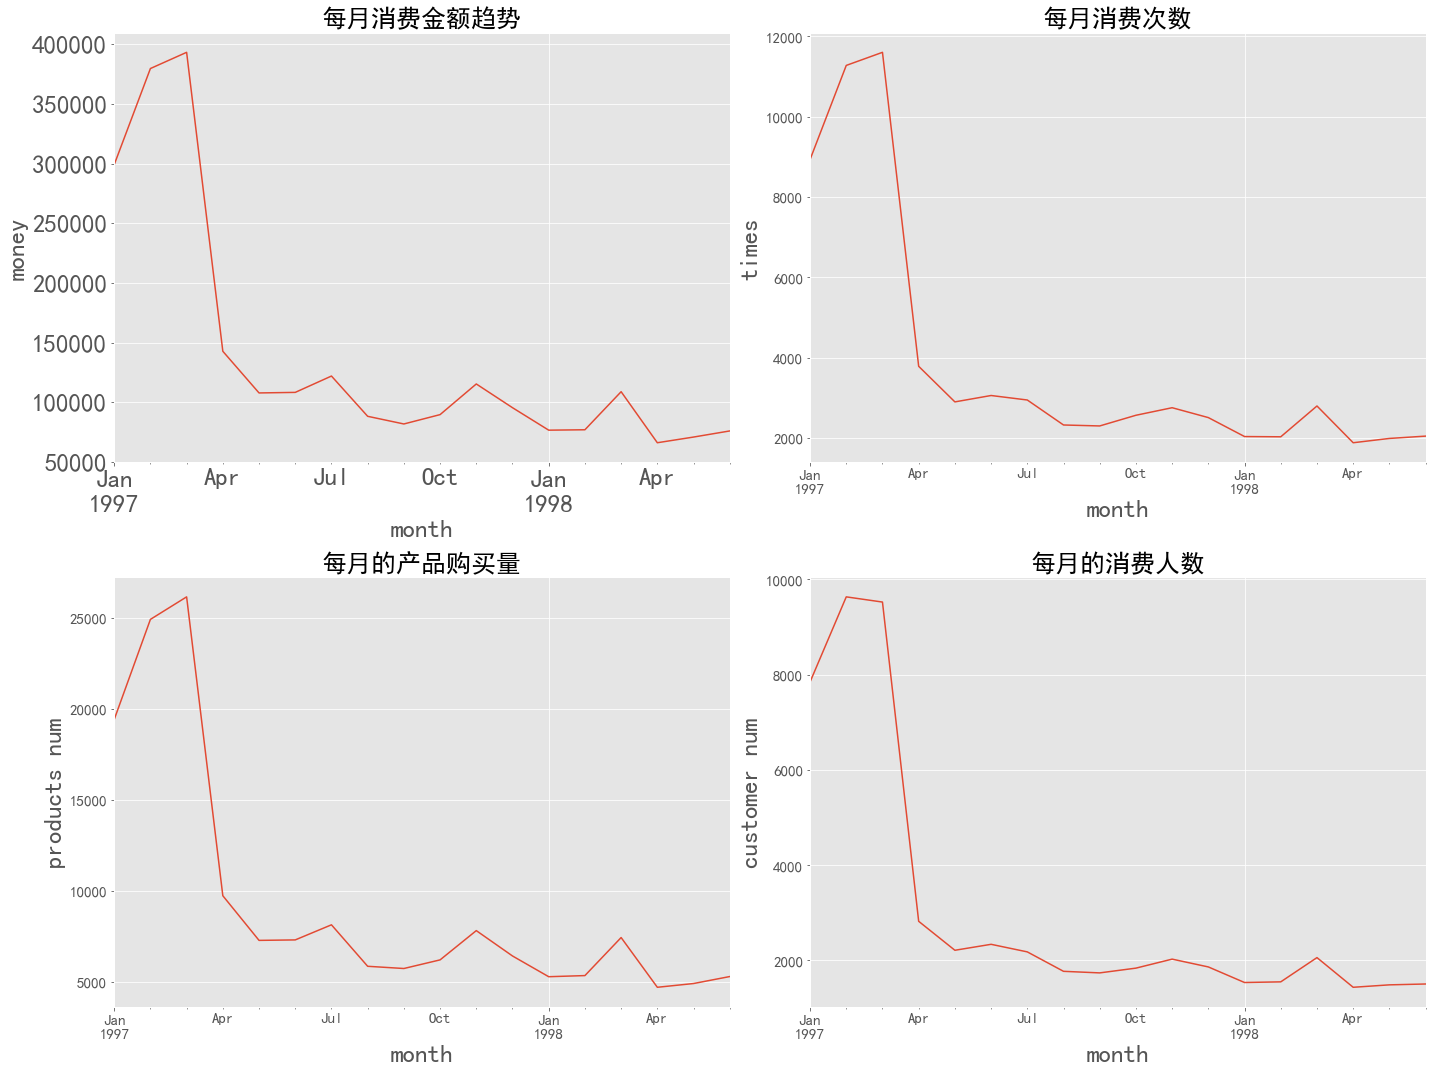

In [10]:

fig, axs = plt.subplots(2, 2, figsize = (20, 15))
# 每月消费金额
df.groupby('month').order_amount.sum().plot(ax = axs[0,0],fontsize=25)
axs[0,0].set_xlabel('month', fontsize=25)
axs[0,0].set_ylabel('money', fontsize=25)
axs[0,0].set_title('每月消费金额趋势', fontsize=25)

# 每月消费次数
df.groupby('month').user_id.count().plot(ax = axs[0,1], fontsize = 15)
axs[0,1].set_xlabel('month', fontsize=25)
axs[0,1].set_ylabel('times', fontsize=25)
axs[0,1].set_title('每月消费次数', fontsize=25)

# 每月的产品购买量
df.groupby('month').order_products.sum().plot(ax = axs[1,0], fontsize = 15)
axs[1,0].set_xlabel('month', fontsize=25)
axs[1,0].set_ylabel('products num', fontsize=25)
axs[1,0].set_title('每月的产品购买量', fontsize=25)

# 每月的消费人数
# 使用nunique()直接返回 数量
df.groupby('month').user_id.nunique().plot(ax = axs[1,1], fontsize = 15)
axs[1,1].set_xlabel('month', fontsize=25)
axs[1,1].set_ylabel('customer num', fontsize=25)
axs[1,1].set_title('每月的消费人数', fontsize=25)

plt.tight_layout()



#### 每月用户平均趋势

In [11]:
# 每月用户平均消费金额
# 每月用户平均消费次数
# 每月用户平均购买量

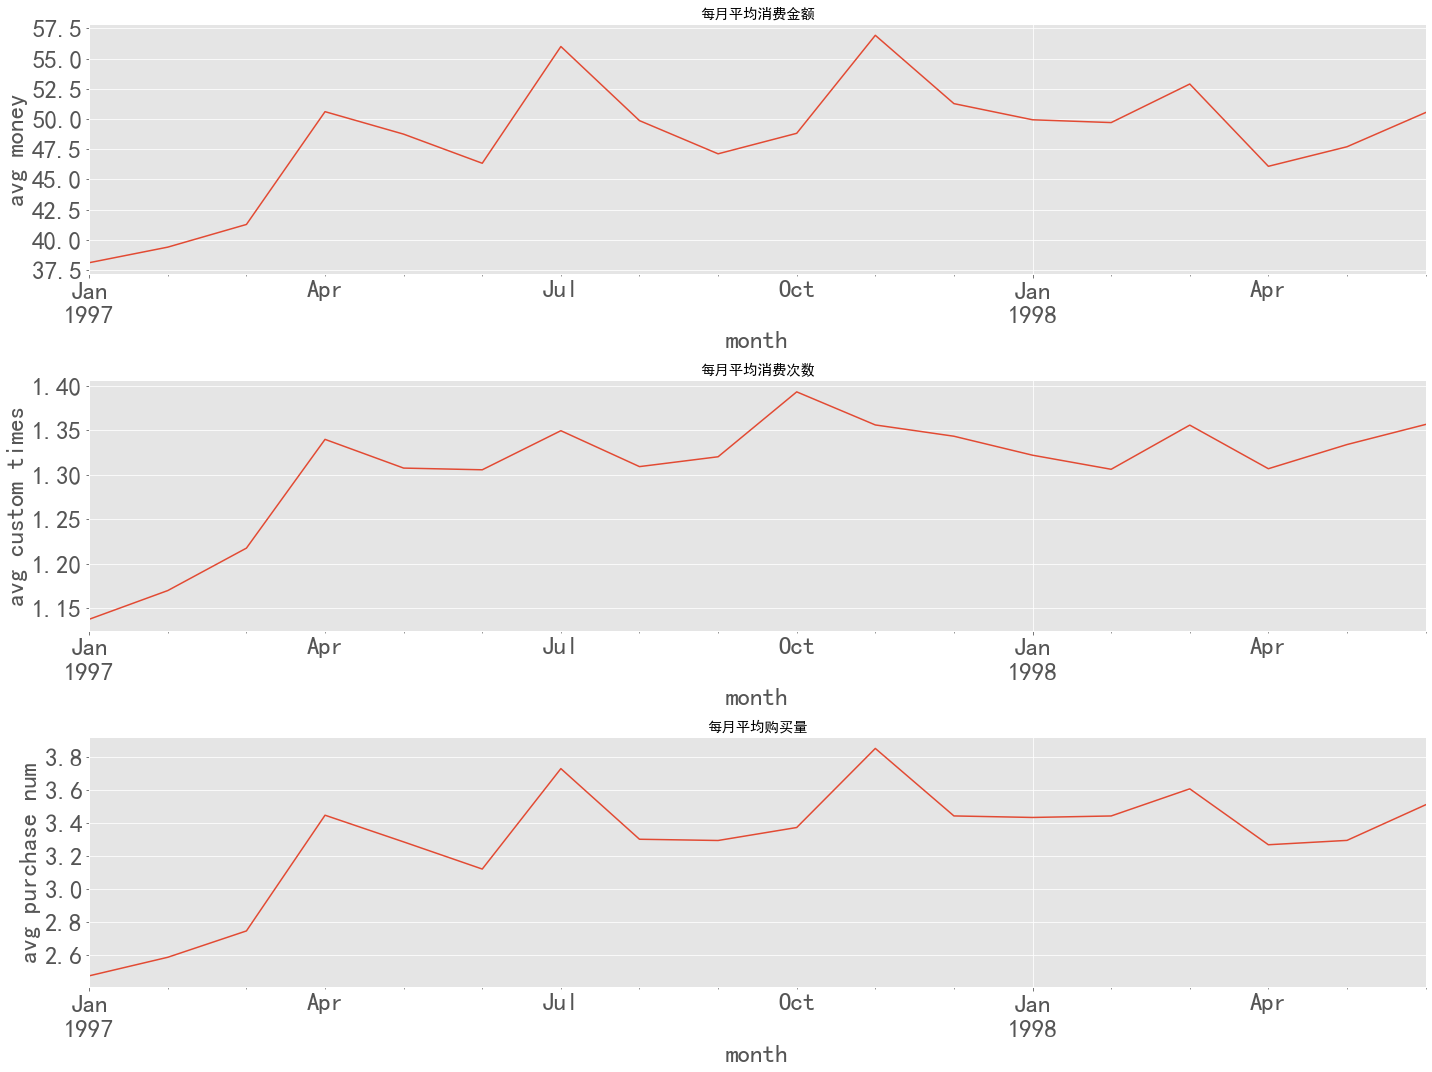

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (20, 15))

groupByMon = df.groupby('month')
num = groupByMon.user_id.nunique()

# 每月用户平均消费金额
# 每月消费总金额/每月消费人数
# 每月的消费总额
total_amount = groupByMon.order_amount.sum()
(total_amount/num).plot(ax = axs[0], fontsize = 25)
axs[0].set_xlabel('month', fontsize = 25)
axs[0].set_ylabel('avg money', fontsize = 25)
axs[0].set_title('每月平均消费金额')

# 每月用户平均消费次数
# 每月的订单数/每月的消费人数
# 每月的订单总量
total_order = groupByMon.user_id.count()
(total_order/num).plot(ax = axs[1], fontsize = 25)
axs[1].set_xlabel('month', fontsize = 25)
axs[1].set_ylabel('avg custom times', fontsize = 25)
axs[1].set_title('每月平均消费次数')


# 每月用户平均购买量
# 每月的产品销售总数/每月的消费人数
# 每月的销售总量
total_product = groupByMon.order_products.sum()
(total_product/num).plot(ax = axs[2], fontsize = 25)
axs[2].set_xlabel('month', fontsize = 25)
axs[2].set_ylabel('avg purchase num', fontsize = 25)
axs[2].set_title('每月平均购买量')
plt.tight_layout()

### 3.2 用户个体消费分析
#### 用户购买量和消费金额的线性回归

In [13]:
user_df = df.groupby('user_id')['order_products', 'order_amount'].sum()
user_df

,order_products,order_amount
user_id,,
1,1,11.77
2,6,89.00
3,16,156.46
4,7,100.50
5,29,385.61
...,...,...
23566,2,36.00
23567,1,20.97
23568,6,121.70


<AxesSubplot:xlabel='order_products', ylabel='order_amount'>

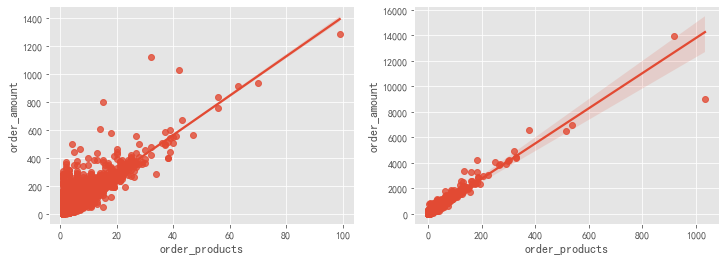

In [14]:
fig, axs = plt.subplots(1,2, figsize = (12, 4))
# 在每一笔订单的层面上进行线性回归分析，分析每笔订单中购买量和金额的线性相关
sns.regplot(x='order_products', y='order_amount', data=df, ax=axs[0])
# 从用户的层面上分析，购买量和金额线性相关
sns.regplot(x='order_products', y='order_amount', data=user_df, ax=axs[1])

In [15]:
from sklearn.model_selection import train_test_split
X = np.array(user_df['order_products']).reshape(-1,1)
y = np.array(user_df['order_amount']).reshape(-1,1)
#划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
#训练模型
linreg.fit(X_train,y_train)
# 独立的线性模型
line_model = np.around(linreg.intercept_, decimals=2)
print('线性模型：{}'.format(line_model))
# 线性回归系数
coefficients = np.around(linreg.coef_, decimals=2)
print('系数：{}'.format(coefficients))
#模型预测
y_pred = linreg.predict(X_test)
from sklearn import metrics
#对模型进行评估
print('线性回归训练集准确率：%.3f'%linreg.score(X_train,y_train)) 

线性模型：[11.66]
系数：[[13.23]]
线性回归训练集准确率：0.938


- 用户的购买量和消费金额基本线性相关，购买越多，金额越高
- 回归方程：$y=13.23X+1$
- 可以通过方程预估达到目标销售额需要多少的销量

#### 用户消费金额和购买数量直方图 
hists中的bins参数是用来划分柱子数量的，默认10。  
用数据除以bins就得到了每个柱子的区间，在区间内的数据量就是柱子的高度。

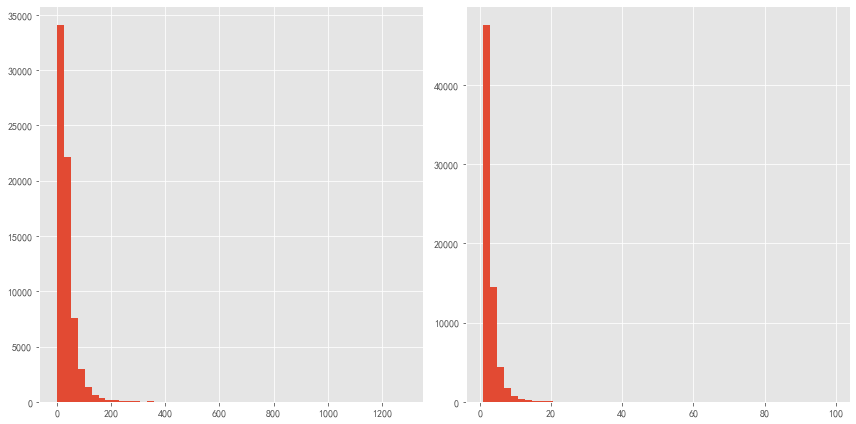

In [16]:
plt.figure(figsize=(12,6))
#第一幅子图:用户消费金额直方图
plt.subplot(121)
plt.hist(df['order_amount'],bins=50)
#第二幅子图:用户消费数量直方图
plt.subplot(122)
plt.hist(df['order_products'],bins =50)
plt.tight_layout()


#### 用户消费累积占比

In [17]:
# cumsum() 的作用是累加所有的值到当前行
# 这里按照订单金额升序排序，作用是画出曲线来观察大客户占整个消费额的比列
user_cumsum = user_df.sort_values('order_amount').apply(lambda x: x.cumsum()/x.sum())
# 因为上面是按照订单金额进行的排序，所以不能使用默认的index 
# 需要重新设置index
user_cumsum.index = range(1, len(user_cumsum)+1)

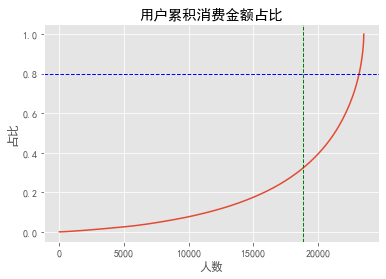

In [18]:
user_cumsum['order_amount'].plot()
plt.title('用户累积消费金额占比')
plt.xlabel('人数')
plt.ylabel('占比')
# 绘制两条参考线
# 水平参考线：0.8的比列
plt.axhline(y=0.8, ls="--", c="b", lw=1)
# 竖直参考线：0.8
plt.axvline(x=len(user_cumsum)*0.8, ls="--", c="g", lw=1)

从设置的参考线来观察，80%的用户所占的销售额不到40%。28定律。

### 3.3 用户行为分析
#### 新增和流失用户变化趋势

Text(0.5, 1.0, '用户流失趋势图')

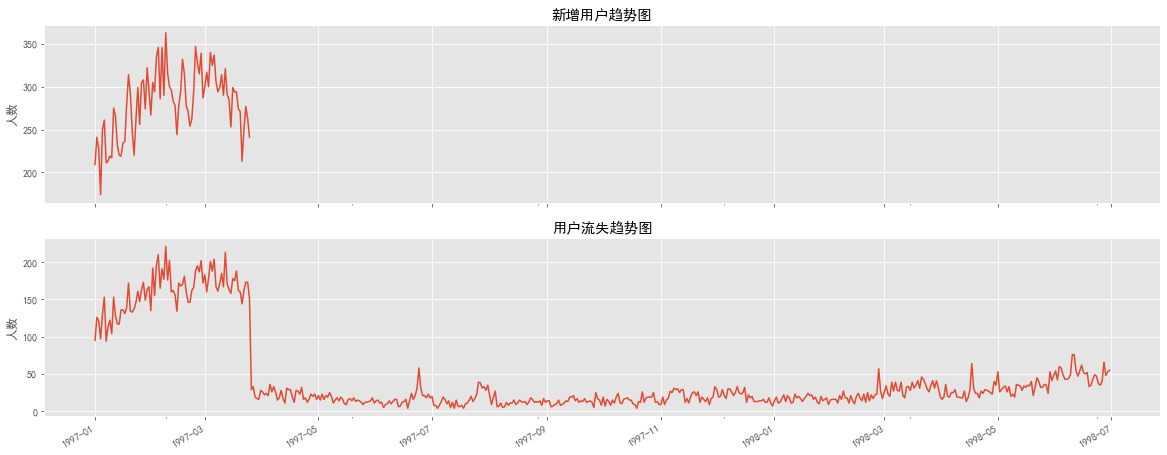

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
grouped_df = df.groupby('user_id')
# 新增用户随时间变化趋势
grouped_df.min().order_dt.value_counts().plot(ax=axs[0])
axs[0].set_ylabel('人数')
axs[0].set_title('新增用户趋势图')
# 流失用户随时间变化趋势
# 统计用户的最后购买时间
grouped_df.max().order_dt.value_counts().plot(ax=axs[1])
axs[1].set_ylabel('人数')
axs[1].set_title('用户流失趋势图')

从新增趋势图来看，只有1997前三个月增加了大量的用户，后面无新增用户。  
从流失趋势图来看，前三个月流失大量的用户，说明有许多的新增用户只购买了一次产品后就不在购买，后面的流失波动不大。

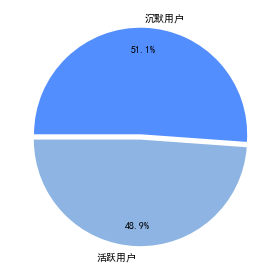

In [20]:
# 分析沉默用户和活跃用户，沉默用户：只消费了一次， 多次消费为活跃用户
# min().order_dt = max().order_dt的为沉默用户，其余为活跃用户
# agg()对分组后的数据进行聚合操作
min_max = grouped_df.order_dt.agg(['min', 'max'])
# 条件筛选出不同的用户
# value_counts()的作用是在指定的列中，找出不同的值，并计算每个值的数量
user_num = (min_max['min']==min_max['max']).value_counts()


plt.pie(user_num,
        autopct = '%.1f%%',
        explode= [0.05,0],
        labels=['沉默用户','活跃用户'],
        colors =['#538EFF','#8DB4E3'],
        pctdistance=0.8,  # 设置百分比标签与圆心的距离
        counterclock = False, # 是否逆时针，这里设置为顺时针方向，人的眼睛都是顺时针方向看
        startangle = 180, # 设置饼图的初始角度
       )
plt.tight_layout()

#### 用户活跃度分层

In [21]:
# 通过每月是否消费来划分用户，缺失值填充0
# pivot_table:数据透视表
purchase_record = df.pivot_table(
    index='user_id', 
    columns='month', 
    values='order_dt',
    aggfunc='count',
    fill_value=0)
# 将有消费记录的 标识为1 没有的为0
# applymap将函数应用于DataFrame的每一个元素
# apply:沿着轴对DataFrame应用函数，axis=1or0
consumer_marked = purchase_record.applymap(lambda x:1 if x>0 else 0)
consumer_marked

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


用户分层（时间窗口设立为 1个月）：  
新用户：第一次消费  
活跃用户：在一个时间窗口内消费两次以上，即在当前月消费后，下月再次消费为活跃用户；  
沉默用户：在当前月消费后，下月无消费记录；  
回流用户：在间隔**一个时间窗口**以上未消费后，再次消费；  
未注册用户  
用户分为上面的集中情况，需要将每个用户在每个月的状态识别出来。  

In [22]:
def user_status(data):
    """
    data:每个用户对应的一行数据，包含每个月里面的购买记录,类型为series
    在第一次购买记录出现以前的状态为未注册用户：直接设置为np.NaN
    第一次购买的状态为新用户：newU
    两次购买记录之间的时间窗口状态为沉默用户：silent(两次记录的间隔大于等于设定的时间窗口
    在间隔一个及以上的时间窗口后有购买记录的为回流用户：reflow
    连续在两个及以上的时间窗口有购买记录的为活跃用户：active
    """

    # 传入的data的类型是series，转换成list
    data = data.tolist()
    # 使用index获取第一次购买记录的索引，并将第一次购买记录的状态修改为newU
    # 每遇见data[i]==1的情况，都需要对tmp_index重新赋值，赋值为最新index
    tmp_index = data.index(1)
    data[tmp_index] = 'newU'
    for i in range(len(data)):
        # 下面if用来跳过已经设置为newU的索引
        if i == tmp_index:
            continue
        # 所有索引位置小于tmp_index的值设置为：unregister
        if i < tmp_index:
            data[i] = np.NaN
        # 如果索引位置的元素值为0，设置状态为slient
        elif data[i] == 0:
            data[i]='silent'
        # 如果索引位置的值为1，且与上一个值为一的索引位置的差等于1，则为活跃用户，active
        elif data[i] == 1 and i-tmp_index != 1:
            data[i] = 'reflow'
            # 重置临时变量的值为最新索引位置
            tmp_index = i
        # 其余情况为回流用户 reflow
        else: 
            data[i] = 'active'
            # data[i] == 1,需要对tmp_index重新赋值
            tmp_index = i
    # 返回series
    return pd.Series(data, index=consumer_marked.columns)

In [23]:
# 对consumer_marked处理，将表中值替换为对应状态
consumer_status = consumer_marked.apply(user_status, axis=1)
consumer_status

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,newU,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent
2,newU,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent
3,newU,silent,reflow,active,silent,silent,silent,silent,silent,silent,reflow,silent,silent,silent,silent,silent,reflow,silent
4,newU,silent,silent,silent,silent,silent,silent,reflow,silent,silent,silent,reflow,silent,silent,silent,silent,silent,silent
5,newU,active,silent,reflow,active,active,active,silent,reflow,silent,silent,reflow,active,silent,silent,silent,silent,silent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23566,NaN,NaN,newU,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent
23567,NaN,NaN,newU,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent
23568,NaN,NaN,newU,active,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent,silent


In [24]:
# 汇总每个月各种状态的用户数量
# 转置后用0填充NaN
sum_status = consumer_status.apply(lambda x: pd.value_counts(x), axis=0).T.fillna(0)
sum_status.head()

,active,newU,reflow,silent
month,,,,
1997-01-01,0.0,7846.0,0.0,0.0
1997-02-01,1157.0,8476.0,0.0,6689.0
1997-03-01,1681.0,7248.0,595.0,14046.0
1997-04-01,1773.0,0.0,1049.0,20748.0
1997-05-01,852.0,0.0,1362.0,21356.0


Text(0, 0.5, 'number')

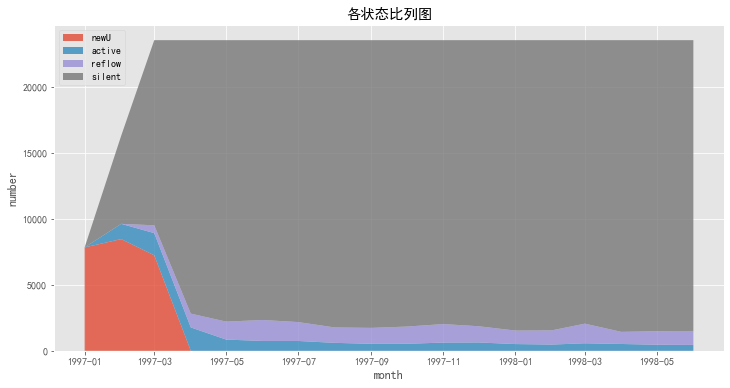

In [25]:
# 绘制堆叠图（stackplots）用来观察每个月的各种用户的比列
status_num = {
    'newU' : sum_status.loc[:, 'newU'],
    'active': sum_status.loc[:, 'active'],
    'reflow': sum_status.loc[:, 'reflow'],
    'silent': sum_status.loc[:, 'silent']
}
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(sum_status.index, status_num.values(), labels=status_num.keys(), alpha=0.8)
ax.legend(loc='upper left')
ax.set_title('各状态比列图')
ax.set_xlabel('month')
ax.set_ylabel('number')

- 红色代表新增用户：只有前四个月大量增加，后面再没有新用户增加。  
- 蓝色代表活跃用户：也是前四个月活跃用户最多，后面趋于平稳。  
- 紫色代表回流用户：从第二月开始有回流用户，三月到四月回流用户的数量大幅下降，后面趋于平稳。  
- 灰色代表沉默用户：沉默用户自97-01开始激增，到97-03达到顶峰，后面一直维持这个数值。

#### 指标
##### a 复购率

In [26]:
# 每月复购率
# 每月有第二次及以上购买记录的用户占总用户的比列
# 先将所有的0替换为NaN空值，这些是没有购买记录的
# 然后将所有购买记录大于2的标识为1，其余的标识为0，后面使用count统计每月总购买用户
# count不会统计NaN
repurchase = purchase_record.applymap(lambda x: 1 if x>1 else np.NaN if x==0 else 0)
# 计算复购率，购买记录大于1的人数/总的购买人数
repurchase_rate = repurchase.apply(lambda x: x.sum()/x.count(), axis=0)
repurchase_rate.head()

month
1997-01-01    0.107571
1997-02-01    0.122288
1997-03-01    0.155292
1997-04-01    0.223600
1997-05-01    0.196929
dtype: float64

Text(0, 0.5, 'rate')

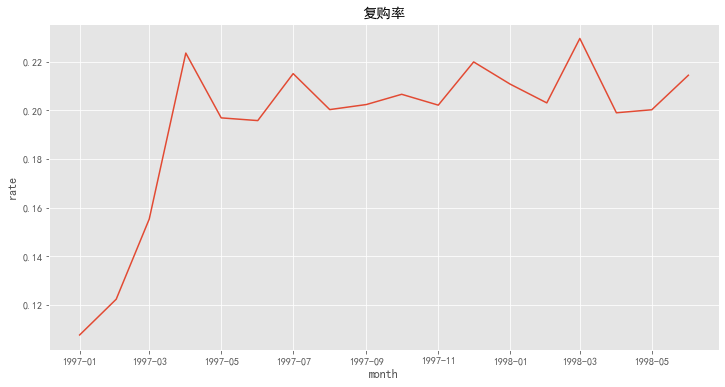

In [27]:
# 绘制折线图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(repurchase_rate.index, repurchase_rate.values)
ax.set_title('复购率')
ax.set_xlabel('month')
ax.set_ylabel('rate')

前四个月有大量只消费了一次的新用户，所以复购率不高。四月都是留存下来的忠实用户，此后的留存率都在20%线上波动。

##### b 回购率
某一个时间窗口里面消费的用户，在下一个时间窗口依然消费。  
本月购买后下一月仍购买的人数/本月购买人数。  

In [28]:
# 编写函数，标识每月的回购用户
# data[i]==data[i+1]==1 标识为1，表示这个用户在下月依然购买了，属于回购用户
# data[i]==1,data[i+1]==0 标识为0，表示这个用户在当月购买了，但是下月没有购买，不属于回购用户，标识为0，利用count求总人数会计算进去
# data[i]==0,标识为NaN，表示这个用户在当月没有购买，count不会统计NaN
# 最后一个月全部标识为NaN，因为没有下一个月的数据进行计算
def reflow_rate(data):
	# 将传入的数据转换为list
	data = data.tolist()
	for i in range(len(data)):
		# 最后一个月，没有下一个月的数据，所以全部标识为0
		if i == len(data) - 1:
			data[i] = np.NaN
			# 结束本次循环
			continue
		if data[i] == 1:
			if data[i+1] == 1:
				# 不用改变值，直接continue结束本次循环
				continue
			else:
				data[i] = 0
		else:
			data[i] = np.NaN
	return pd.Series(data, index=consumer_marked.columns)

In [29]:
# 计算每个月的回购率
reflow_consumer = consumer_marked.apply(reflow_rate, axis=1).apply(lambda x: x.sum()/x.count())

Text(0, 0.5, 'rate')

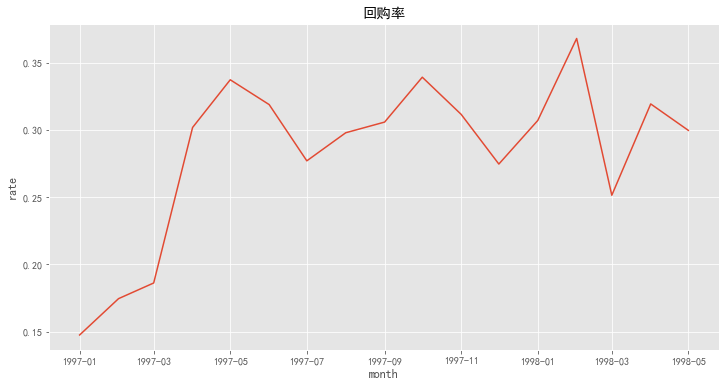

In [30]:
# 绘制折线图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(reflow_consumer.index, reflow_consumer.values)
ax.set_title('回购率')
ax.set_xlabel('month')
ax.set_ylabel('rate')

- 前五个月的回购率持续增长，到第五月达到连续增长的顶峰。
- 自第五月后，回购率在30%线上波动，波动范围总体在上下5%的范围
##### 留存率
以第一个月的新增用户来计算随时间变化的留存率。  

In [31]:
# 第一个月新增用户
new_user = consumer_marked.loc[:, '1997-01-01'].sum()

# 编写函数计算第一个月新增用户，后面的消费情况
# 第一个月新增的，后面每个月有消费记录的标识为1，即data[0]==1 and data[i]==1 标识为1（i>0
# start_position:选取从哪个月开始计算新增用户
def retentation(data, start_position):
	data = data.tolist()
	for i in range(start_position + 1, len(data)):
		if data[start_position] == 1 and data[i] == 1:
			data[i] = 1
		else:
			data[i] = 0
	return pd.Series(data, index=consumer_marked.columns)

In [32]:
retentation_rate = consumer_marked.apply(lambda x: retentation(x, 0), axis=1).apply(lambda x: x.sum()/new_user)
retentation_rate

month
1997-01-01    1.000000
1997-02-01    0.147464
1997-03-01    0.122865
1997-04-01    0.103237
1997-05-01    0.086541
1997-06-01    0.093806
1997-07-01    0.091767
1997-08-01    0.074178
1997-09-01    0.071246
1997-10-01    0.075707
1997-11-01    0.085776
1997-12-01    0.080806
1998-01-01    0.067295
1998-02-01    0.065129
1998-03-01    0.084629
1998-04-01    0.060158
1998-05-01    0.063344
1998-06-01    0.063472
dtype: float64

Text(0, 0.5, 'rate')

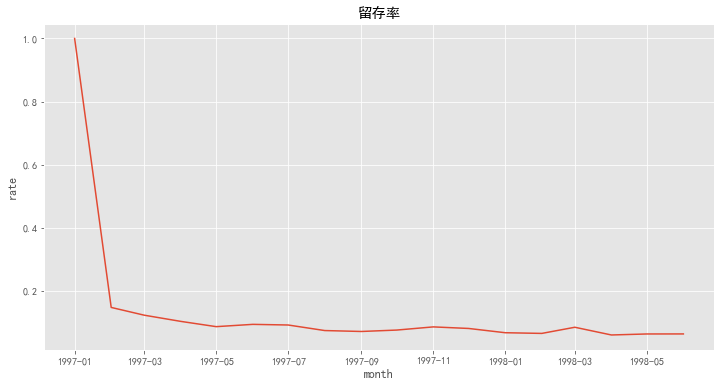

In [33]:
# 绘制柱状图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(retentation_rate.index[:], retentation_rate.values[:])
ax.set_title('留存率')
ax.set_xlabel('month')
ax.set_ylabel('rate')

第一个月当月的留存率100%是因为一月是起点，所有人都有购买记录所以是100%。  
第二月开始留存率大幅下降，并且从后保持一个平稳的趋势，说明有一部分忠实的客户来维持这个平稳的走势。  
一月到二月下降的则代表流失的新用户。  

### 3.4 用户价值分析（RFM模型)
![](./RFM.jpg)
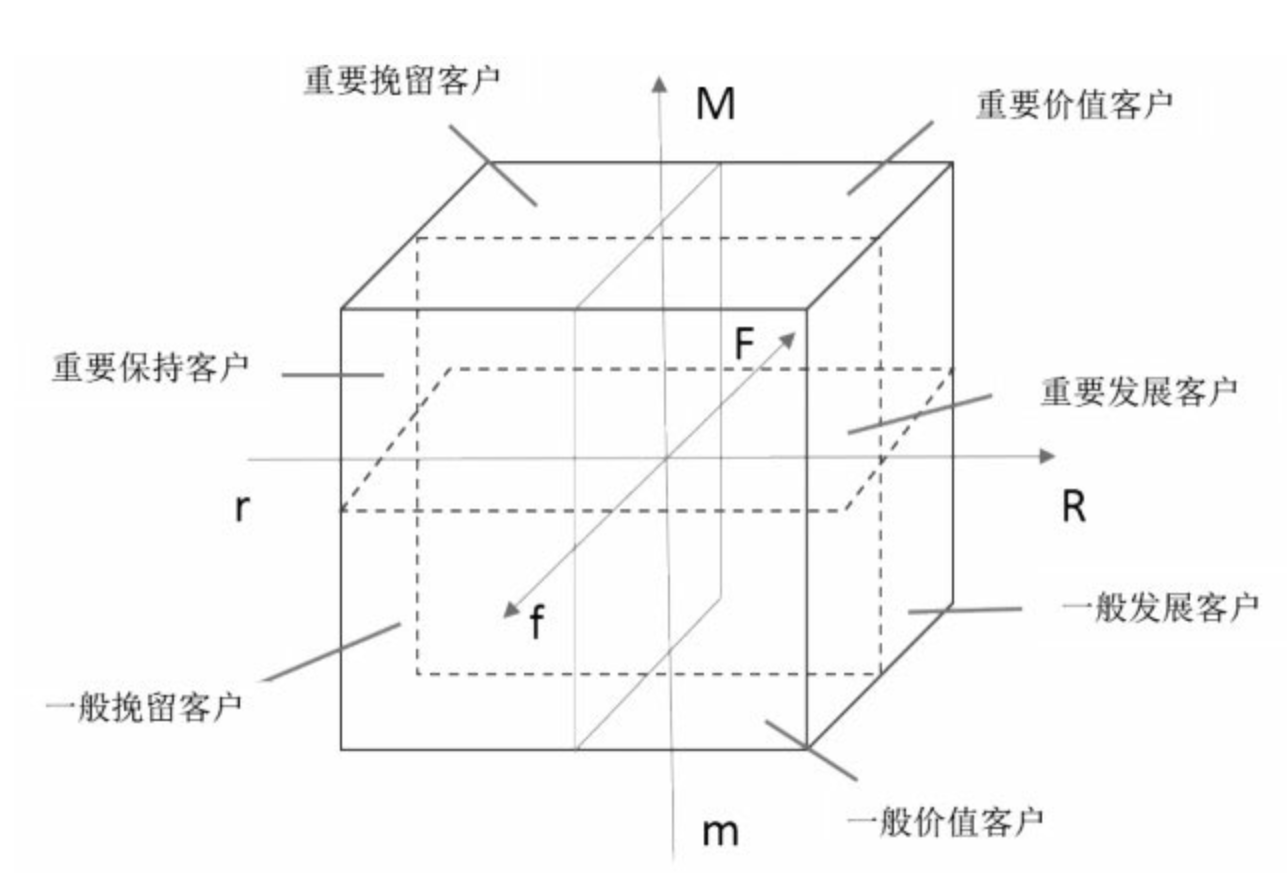

In [34]:
# 对数据进行透视
pivot_df = df.pivot_table(index="user_id", 
                values=["order_dt", "order_products", "order_amount"],
                aggfunc = {"order_dt":"max", "order_products":"count","order_amount":"sum"}
                )
pivot_df.head()

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,2
3,156.46,1998-05-28,6
4,100.50,1997-12-12,4
5,385.61,1998-01-03,11


In [35]:
# 因为数据集是截取的某一段时间的数据，所以本应该使用today作为计算最近购买间隔时间的节点
# 改为使用数据集中最大的日期作为节点计算最近购买时间间隔
pivot_df["R"] = (pivot_df.order_dt.max() - pivot_df.order_dt)/np.timedelta64(1, "D")
pivot_df.rename(columns={"order_amount":"M", "order_products":"F"}, inplace=True)
del pivot_df["order_dt"]

In [36]:
# 计算每个纬度的均值，衡量用户等级
# 计算后的结果中
# R<0:表示最近购买时间比均值小(优)，反之比均值大(一般)
# F>0:表示消费频次比均值高（优），反之比均值低（一般）
# M>0:表示消费金额比均值高（优），反之比均值低（一般）
pivot_df = pivot_df[["R", "F", "M"]].apply(lambda x:x-x.mean())
# 对R取反，方便后面分类
# 取反后 R>0的价值大于R<0的用户价值
pivot_df["R"] = -pivot_df.R
pivot_df

,R,F,M
user_id,,,
1,-177.778362,-1.955409,-94.310426
2,-166.778362,-0.955409,-17.080426
3,334.221638,3.044591,50.379574
4,167.221638,1.044591,-5.580426
5,189.221638,8.044591,279.529574
...,...,...,...
23566,-94.778362,-1.955409,-70.080426
23567,-94.778362,-1.955409,-85.110426
23568,-66.778362,0.044591,15.619574


In [37]:
# 定义一个分类函数，将用户分成不同的等级
def classify(x):
	# 利用0和1标识对大于0和小于0两种情况进行标识
	# R=0 的价值大于 R=1
	# F和M 都是"=1"的价值大于"=0"的价值
	level = x.apply(lambda x:"1" if x>=0 else "0")
	label = level.R + level.F + level.M
	# 创建字典，分类不同等级
	levelDict = {
		"111":"重要价值客户",
		"110":"一般价值客户",
		"101":"重要发展客户",
		"100":"一般发展客户",
		"011":"重要保持客户",
		"010":"一般保持客户",
		"001":"重要挽留客户",
		"000":"一般挽留客户"
	}
	result = levelDict[label]
	return result

# axis = 0(default):一列一列执行
# axis = 1：一行一行执行
pivot_df["label"] = pivot_df.apply(classify, axis=1)

<AxesSubplot:ylabel='None'>

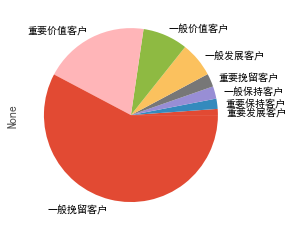

In [38]:
pivot_df.groupby("label").size().sort_values().plot.pie()

### 3.5 用户消费周期分析

In [39]:
# 错行计算每位用户相邻两个订单之间的时间间隔 diff()（default preview a row)
order_dt_diff = df.groupby("user_id").apply(lambda x:x["order_dt"].diff())
order_dt_diff

user_id       
1        0           NaT
2        1           NaT
         2        0 days
3        3           NaT
         4       87 days
                   ...  
23568    69654   11 days
         69655   17 days
23569    69656       NaT
23570    69657       NaT
         69658    1 days
Name: order_dt, Length: 69659, dtype: timedelta64[ns]

In [40]:
# 消费周期统计分析
order_dt_diff.describe()

count                         46089
mean     68 days 23:22:13.567662566
std      91 days 00:47:33.924168893
min                 0 days 00:00:00
25%                10 days 00:00:00
50%                31 days 00:00:00
75%                89 days 00:00:00
max               533 days 00:00:00
Name: order_dt, dtype: object

Text(0, 0.5, '人数')

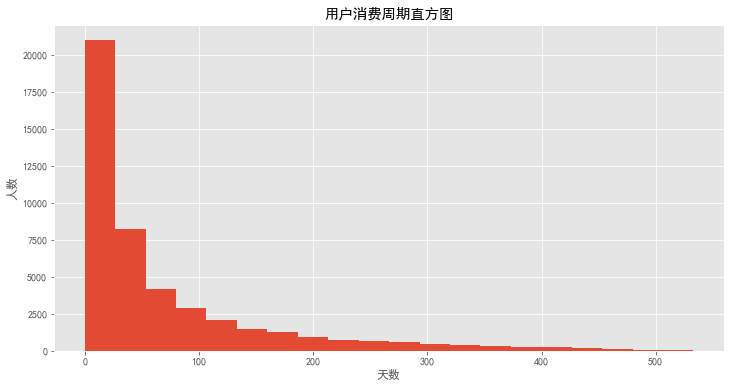

In [41]:
(order_dt_diff/np.timedelta64(1, "D")).hist(bins=20, figsize=(12, 6))
plt.title("用户消费周期直方图")
plt.xlabel("天数")
plt.ylabel("人数")

### 3.6 用户生命周期（首次购买和最后一次购买）

In [42]:
user_lif_period = min_max["max"] - min_max["min"]
# 用户平均生命周期
user_lif_period.mean()

Timedelta('134 days 20:55:36.987696224')

Text(0, 0.5, '人数')

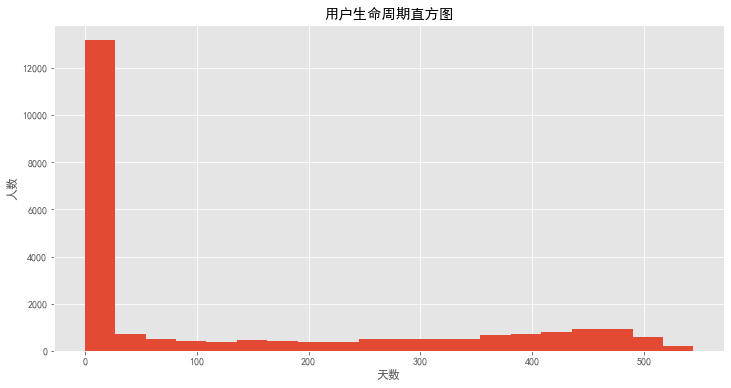

In [43]:
# 用户生命周期分布
(user_lif_period/np.timedelta64(1, "D")).hist(bins=20, figsize=(12, 6))
plt.title("用户生命周期直方图")
plt.xlabel("天数")
plt.ylabel("人数")

In [44]:
# 只消费一次的用户数量超过了一半，排除只消费一次的用户
# 只对多次消费的用户进行分析
user_lif_period = user_lif_period.reset_index()
user_lif_period.columns = ["user_id", "生命周期/days"]
user_lif_period["生命周期"] = user_lif_period["生命周期/days"]/np.timedelta64(1,"D")

<AxesSubplot:>

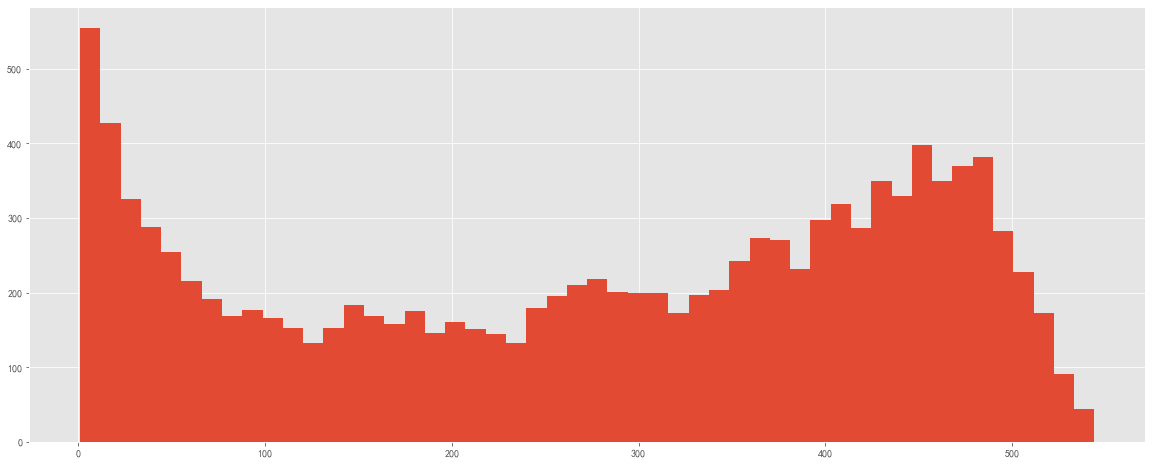

In [45]:
user_lif_period[user_lif_period.生命周期>0].生命周期.hist(bins=50, figsize=(20, 8))

In [46]:
user_lif_period[user_lif_period.生命周期>0]["生命周期/days"].mean()

Timedelta('276 days 01:04:31.344216740')

## 4 结论和建议

### 4.1 结论

1. 在1997年有大量新用户涌入，消费金额、消费人数、消费次数、购买量都达到顶峰。然而着三个月也是用户流失的三个月，说明许多新用户只购买一次就流失了，可能是被活动吸引购买。
2. 用户购买量和消费金额呈线性关系，线性方程$y=13.23x+1$;消费符合长尾分布，大部分用户消费金额在100以内，购买量在10张以内；80%的用户贡献不到40%；
3. 在1997年前三个月，大部分的新用户涌入后只购买了一次，就不再购买，用户粘性不高，流失过快。
4. 从RFM模型来看，“重要价值客户”消费频次和金额最高，人数第二；“一般挽留用户”，人数最多，消费频次和购买金额第二。
5. 用户生命周期：由于只购买一次的用户占比接近一半，排除这部分用户的影响后，用户的平均生命周期是276天。

### 4.2 建议

1. 找出1997年前三个月用户大量涌入但快速流失的原因，然后根据原因指定策略提高用户粘性。
2. 根据回归方程可以粗略的得出要满足KPI，需要售卖多少张CD，然后根据销量目标进一步指定营销策略。
3. 根据用户的价值，对重要价值用户采用vip服务，重要发展用户想办法提高消费频率，重要保持用户主动发短信促成购买。


<!--[参考](https://www.heywhale.com/mw/project/61348efebc40120017e9f982/content)-->
